In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.mane_utils import *
from scripts.plotting import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [9]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]
pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]



sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]
m_ab = '../'+expand(config['data']['ab'], species='mouse')[0]
m_filt_ab = '../'+expand(config['data']['filt_ab'], species='mouse')[0]
m_read_annot = '../'+expand(config['data']['read_annot'], species='mouse')[0]
m_t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='mouse')[0]
m_swan_file = '../'+expand(config['data']['sg'], species='mouse')[0]
m_cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='mouse')[0]
m_pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_major_isos = '../'+expand(config['data']['major_isos'], species='mouse', obs_col='sample')[0]
m_pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='mouse')[0]
m_ref_t_metadata = '../'+expand(config['ref']['t_info'], species='mouse')[0]
m_ref_g_metadata = '../'+expand(config['ref']['g_info'], species='mouse')[0]


mouse_ver = 'vM25_cerberus'

In [10]:
species = 'human'

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2154: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 187945
Found 50 total samples
697385
545189
Median predominant transcripts / gene: 2.0
17523
12794
12794/17523 73.01% protein-coding genes have >1 predominant isoforms across samples


<Figure size 216x360 with 0 Axes>

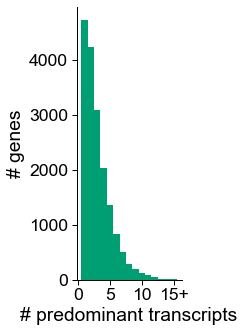

In [11]:
fname = 'figures/predom_isos_per_gene.pdf'
df, gb_df = plot_n_predom_transcripts(pi_tpm_table,
                          filt_ab,
                          ver,
                          gene_subset,
                          min_tpm,
                          fname,
                          species='human',
                          max_isos=15,
                          figsize=(3,5))

In [13]:
# get unique transcript gene combinationes
df = df[['tid', 'gid', 'gname']].drop_duplicates()
ca = cerberus.read(cerberus_h5)
gtf_df,_,_ = get_gtf_info(ver='v40_cerberus', add_stable_gid=True)

In [15]:
# what does diversity look like between these guys? 
tids = df.tid.tolist() 
df = ca.get_subset_triplets(tids, source='predominant_isos')
df.rename({'gene_id':'gid'}, axis=1, inplace=True)
df = df.merge(gtf_df[['gid_stable', 'gname', 'biotype_category']], how='left', left_on='gid', right_on='gid_stable')
ca.add_triplets(df)

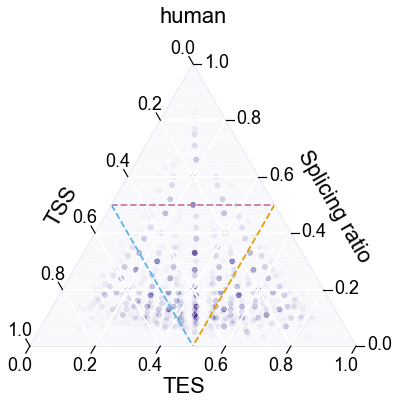

<Figure size 432x288 with 0 Axes>

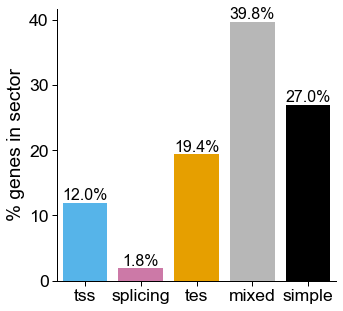

<Figure size 432x288 with 0 Axes>

In [16]:
c_dict, order = get_sector_colors()

fname = f'figures/{species}_predominant_simplex.pdf'
subset = {'source': 'predominant_isos'}
title = species

temp = ca.plot_simplex(top='splicing_ratio',
        subset=subset,
        density=True,
        density_scale=100,
        density_cmap='Purples',
        log_density=True,
        sectors=True,
        scatter=False,
        legend=False,
        title=title,
        size_scale=0.6,
        density_cbar=False,
        fname=fname)

plt.show()
plt.clf()


temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid': 'n_genes'}, axis=1)
temp['total'] = temp.n_genes.sum()
temp['perc'] = (temp['n_genes']/temp['total'])*100

sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(5,5))

ax = sns.barplot(data=temp, y='perc', x='sector',
                 palette=c_dict, order=order,
                 saturation=1)
                 # , height=3, aspect=1.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('% genes in sector')
ax.set_xlabel('')

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

add_perc_2(ax)
fname = f'figures/{species}_genes_per_sector.pdf'
plt.savefig(fname, dpi=500)
plt.show()
plt.clf()

In [19]:
species = 'mouse'

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 127084
Found 37 total samples
463280
351143
Median predominant transcripts / gene: 2.0
17244
9945
9945/17244 57.67% protein-coding genes have >1 predominant isoforms across samples


<Figure size 216x360 with 0 Axes>

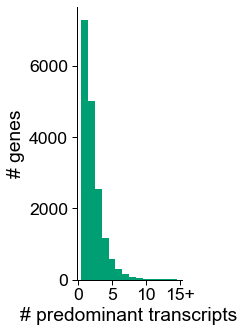

In [37]:
fname = 'figures/predom_isos_per_gene.pdf'
df, gb_df = plot_n_predom_transcripts(m_pi_tpm_table,
                          m_filt_ab,
                          mouse_ver,
                          gene_subset,
                          min_tpm,
                          fname,
                          species='mouse',
                          max_isos=15,
                          figsize=(3,5))

In [38]:
# get unique transcript gene combinationes
df = df[['tid', 'gid', 'gname']].drop_duplicates()

In [33]:
ca = cerberus.read(m_cerberus_h5)

In [34]:
gtf_df,_,_ = get_gtf_info(ver='vM25_cerberus', add_stable_gid=True)

,gid,gname,length,biotype,biotype_category,tf,MANE_Select,MANE_Plus_Clinical,gid_stable
0,ENSMUSG00000000544.14,Gpa33,36373,protein_coding,protein_coding,False,False,False,ENSMUSG00000000544
1,ENSMUSG00000001138.13,Cnnm3,16471,protein_coding,protein_coding,False,False,False,ENSMUSG00000001138
2,ENSMUSG00000003135.15,Cnot11,11998,protein_coding,protein_coding,False,False,False,ENSMUSG00000003135
3,ENSMUSG00000003464.13,Pex19,9839,protein_coding,protein_coding,False,False,False,ENSMUSG00000003464
4,ENSMUSG00000004552.16,Ctse,37300,protein_coding,protein_coding,False,False,False,ENSMUSG00000004552


In [45]:
# what does diversity look like between these guys? 
tids = df.tid.tolist() 
df = m_ca.get_subset_triplets(tids, source='predominant_isos')
df.rename({'gene_id':'gid'}, axis=1, inplace=True)
df = df.merge(gtf_df[['gid_stable', 'gname', 'biotype_category']], how='left', left_on='gid', right_on='gid_stable')
ca.add_triplets(df)


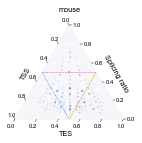

<Figure size 432x288 with 0 Axes>

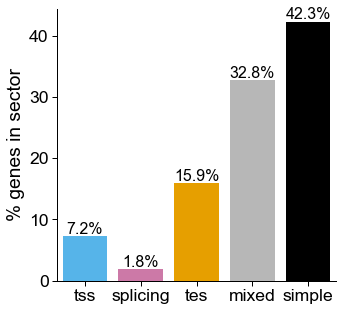

<Figure size 432x288 with 0 Axes>

In [49]:
c_dict, order = get_sector_colors()

fname = f'figures/{species}_predominant_simplex.pdf'
subset = {'source': 'predominant_isos'}
title = species

temp = ca.plot_simplex(top='splicing_ratio',
        subset=subset,
        density=True,
        density_scale=100,
        density_cmap='Purples',
        log_density=True,
        sectors=True,
        scatter=False,
        legend=False,
        title=title,
        size_scale=0.2,
        density_cbar=False,
        fname=fname)

plt.show()
plt.clf()


temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid': 'n_genes'}, axis=1)
temp['total'] = temp.n_genes.sum()
temp['perc'] = (temp['n_genes']/temp['total'])*100

sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(5,5))

ax = sns.barplot(data=temp, y='perc', x='sector',
                 palette=c_dict, order=order,
                 saturation=1)
                 # , height=3, aspect=1.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('% genes in sector')
ax.set_xlabel('')

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

add_perc_2(ax)
fname = f'figures/{species}_genes_per_sector.pdf'
plt.savefig(fname, dpi=500)
plt.show()
plt.clf()

In [57]:
# temp = ca.triplets.loc[ca.triplets.source=='predominant_isos']

In [56]:
# temp.sort_values(by='n_iso', ascending=False)

In [55]:
# temp.sort_values(by='splicing_ratio', ascending=False).head()

In [62]:
ca.triplets = cerberus.assign_sector(ca.triplets)
c_dict, order = get_sector_colors()

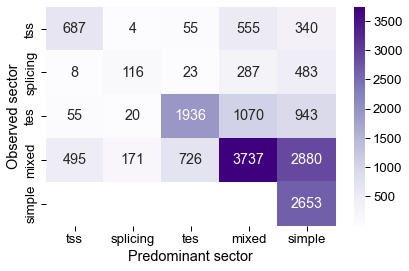

<Figure size 432x288 with 0 Axes>

In [88]:
# how does overall sector of gene relate to the predominant sector of genes?
obs_source = 'obs_det'
predom_source = 'predominant_isos'

df = compute_dists([ca, ca],
                   [obs_source, 
                   predom_source],
                   gene_subsets=[gene_subset, gene_subset],
                   ver=[mouse_ver,  mouse_ver])

sect1 = f'sector_{obs_source}'
sect2 = f'sector_{predom_source}'
temp = df[[sect1, sect2, 'gid']]
temp = temp.groupby([sect1, sect2]).count().reset_index().rename({'gid': 'n_genes'}, axis=1)

temp[sect1] = pd.Categorical(temp[sect1],
                             categories=order,
                             ordered=True)
temp[sect2] = pd.Categorical(temp[sect2],
                             categories=order,
                             ordered=True)
temp = temp.pivot(index=sect1, columns=sect2, values='n_genes')

sns.set_context('paper', font_scale=1.5)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# using the upper triangle matrix as mask 
ax =  sns.heatmap(temp, annot=True,
                  fmt='.0f',
                  cmap='Purples')
ax.set(ylabel='Observed sector', xlabel='Predominant sector')
plt.tight_layout()
plt.show()
plt.clf()

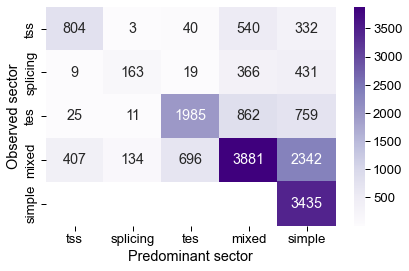

<Figure size 432x288 with 0 Axes>

In [89]:
# how does overall sector of gene relate to the predominant sector of genes?
obs_source = 'obs_major'
predom_source = 'predominant_isos'

df = compute_dists([ca, ca],
                   [obs_source, 
                   predom_source],
                   gene_subsets=[gene_subset, gene_subset],
                   ver=[mouse_ver,  mouse_ver])

sect1 = f'sector_{obs_source}'
sect2 = f'sector_{predom_source}'
temp = df[[sect1, sect2, 'gid']]
temp = temp.groupby([sect1, sect2]).count().reset_index().rename({'gid': 'n_genes'}, axis=1)

temp[sect1] = pd.Categorical(temp[sect1],
                             categories=order,
                             ordered=True)
temp[sect2] = pd.Categorical(temp[sect2],
                             categories=order,
                             ordered=True)
temp = temp.pivot(index=sect1, columns=sect2, values='n_genes')

sns.set_context('paper', font_scale=1.5)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# using the upper triangle matrix as mask 
ax =  sns.heatmap(temp, annot=True,
                  fmt='.0f',
                  cmap='Purples')
ax.set(ylabel='Observed sector', xlabel='Predominant sector')
plt.tight_layout()
plt.show()
plt.clf()